## 1. Preprocessing

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [152]:
# Import the data set 
df = pd.read_excel("Liquors_dataset.xlsx",header = 0)

# fix numerical types
df = df.applymap(lambda x: x.replace("\t","") if type(x) == str else x)
df = df.applymap(lambda x: x.replace(" ","") if type(x) == str else x)
df = df.applymap(lambda x: float(x) if isinstance(x,str) and x.replace(".","").isdigit() else x) 


In [153]:
df.head()

,Order Id,Product categorie,Product subcategorie,Product reference,Product quantity,Total price (unit price x product quantity),Supplier country,Supplier ID
0,61865,Spirits,Anise,483222,2,14.90,Spain,1
1,62447,Wine,Rosé,822222,12,64.20,Spain,1
2,64401,Spirits,Herballiquor,434732,1,13.15,Spain,2
3,64588,Wine,red,600772,30,172.50,Spain,3
4,64674,Spirits,Tequila,857357,1,36.70,Spain,1


In [154]:
# Check if there is any missing values
df.isna().sum()

Order Id                                         0
Product categorie                                0
Product subcategorie                           841
Product reference                                0
Product quantity                                 0
Total price (unit price x product quantity)      0
Supplier country                                 0
Supplier ID                                      0
dtype: int64

In [155]:
# General info on dataset

print("Number of columns: ",df.shape[1], "/ Number of rows: ",df.shape[0])
print("\nFeatures: ")
print(list(df.columns))
print("\nUnique values per feature: ")
print("\n Product categorie: ", df["Product categorie"].unique())
print("\n Supplier country: ", df["Supplier country"].unique())
print("\nNumber of Orders: ", len(df["Order Id"].unique()))
print("\nNumber of references: ", len(df["Product reference"].unique()))
print("\nNumber of subcategories: ", len(df["Product subcategorie"].unique()))

Number of columns:  8 / Number of rows:  392105

Features: 
['Order Id', 'Product categorie', 'Product subcategorie', 'Product reference', 'Product quantity', 'Total price (unit price x product quantity)', 'Supplier country', 'Supplier ID']

Unique values per feature: 

 Product categorie:  ['Spirits' 'Wine' 'Accessories' 'Gourmet' 'Lotsandgifts' 'Beer'
 'Christmasgifts']

 Supplier country:  ['Spain' 'Germany' 'Italy' 'France' 'Portugal' 'UnitedKingdom'
 'Netherlands' 'Belgium' 'Serbia' 'Luxembourg' 'Greece']

Number of Orders:  217988

Number of references:  58168

Number of subcategories:  169


#### Orders with null subcategorie represents only 0.2% of orders, we can drop them in order to get a homogeneous dataset.


In [156]:
# Droping rows where product subcategorie is missing
df = df.dropna()
print("New shape:",df.shape)
df.isna().sum()

New shape: (391264, 8)


Order Id                                       0
Product categorie                              0
Product subcategorie                           0
Product reference                              0
Product quantity                               0
Total price (unit price x product quantity)    0
Supplier country                               0
Supplier ID                                    0
dtype: int64

In [157]:
# Changing the name of columns Total price 
names = df.columns.tolist()
names[names.index('Total price (unit price x product quantity)')] = 'Total price'
df.columns = names

In [158]:
df.head()

,Order Id,Product categorie,Product subcategorie,Product reference,Product quantity,Total price,Supplier country,Supplier ID
0,61865,Spirits,Anise,483222,2,14.90,Spain,1
1,62447,Wine,Rosé,822222,12,64.20,Spain,1
2,64401,Spirits,Herballiquor,434732,1,13.15,Spain,2
3,64588,Wine,red,600772,30,172.50,Spain,3
4,64674,Spirits,Tequila,857357,1,36.70,Spain,1


In [159]:
# More info

df_ref = df.groupby(['Product reference','Product categorie']).count()
df_ref = df_ref.sort_values('Order Id')

# Top 3 Least sold products
print("Top 3 least sold products")
df_ref['Order Id'].head(3)


Top 3 least sold products


Product reference  Product categorie
1029347            Wine                 1
1065903            Wine                 1
1065955            Wine                 1
Name: Order Id, dtype: int64

In [160]:
# Top 3 most sold products 
print("Top 3 most sold products")
df_ref["Order Id"].tail(3)


Top 3 most sold products


Product reference  Product categorie
436890             Spirits              2695
449875             Spirits              2906
435488             Spirits              3164
Name: Order Id, dtype: int64

# 2. Data visualization

## Number of sales per categorie

In [163]:
df_categorie = df.groupby(['Product categorie']).count()
df_categorie["Order Id"].head()

Product categorie
Accessories       1466
Beer              9337
Christmasgifts      99
Gourmet           9409
Lotsandgifts      3352
Name: Order Id, dtype: int64

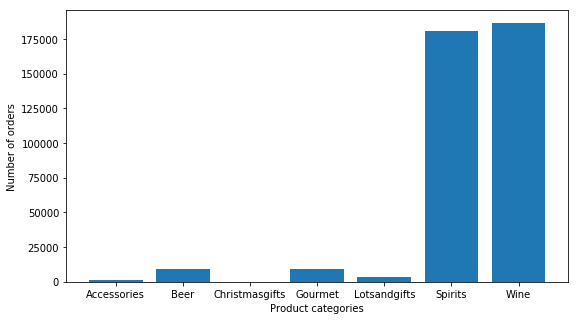

In [164]:

plt.figure(1, figsize=(9,5))
plt.bar(df_categorie.index,df_categorie['Order Id'])
plt.xlabel("Product categories")
plt.ylabel("Number of orders")
plt.savefig('num_sales_category.png')


## Average price by category


In [165]:
df["Unit price"] = df["Total price"] / df["Product quantity"]
df_price = df.groupby("Product categorie")["Unit price"].mean()
df_price = df_price.apply(lambda x: round(x,2))

In [166]:
df_price.head(10)

Product categorie
Accessories       45.52
Beer               4.46
Christmasgifts    54.94
Gourmet            8.55
Lotsandgifts      47.18
Spirits           26.29
Wine              17.08
Name: Unit price, dtype: float64

Text(0.5, 1.0, 'Average price per categorie')

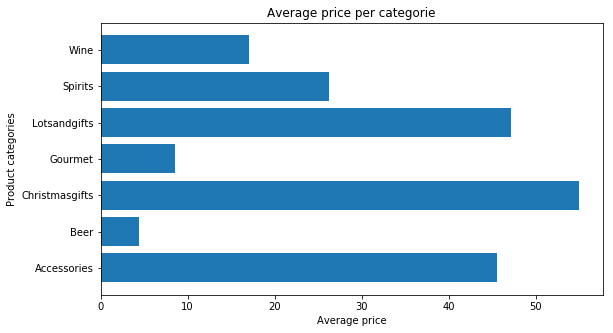

In [167]:

plt.figure(1, figsize=(9,5))
plt.barh(df_price.index,list(df_price) )
plt.xlabel("Average price")
plt.ylabel("Product categories")
plt.title("Average price per categorie")



## Contribution of each category in total revenue

In [168]:
df_contri = df.groupby("Product categorie")["Total price"].sum()
df_contri = df_contri/sum(df["Total price"])*100
df_contri = df_contri.apply(lambda x : round(x,2))

In [169]:
df_contri.head(10)

Product categorie
Accessories        0.31
Beer               0.71
Christmasgifts     0.03
Gourmet            0.77
Lotsandgifts       0.81
Spirits           49.62
Wine              47.75
Name: Total price, dtype: float64

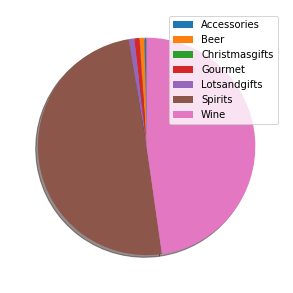

In [170]:

plt.figure(1, figsize=(9,5))    
patches, texts = plt.pie(list(df_contri),shadow=True, startangle=90)
plt.legend(patches, df_contri.index, loc="best")
plt.savefig('cont_category.png')

# 3. Average basket analysis

In [171]:
averg_basket = round(sum(df["Total price"]) / len(df["Order Id"].unique()),2)
print("Average basket values: ", averg_basket)

Average basket values:  132.56


### Average basket per country of origin

In [172]:
num_orders = df.groupby('Supplier country').nunique()['Order Id']
df_country = df.groupby('Supplier country').sum()["Total price"]/num_orders
df_country = df_country.apply(lambda x : round(x,2))

In [173]:
df_country

Supplier country
Belgium          140.84
France           193.89
Germany          107.36
Greece           120.15
Italy            156.93
Luxembourg       303.86
Netherlands      121.20
Portugal         107.65
Serbia            78.23
Spain            126.95
UnitedKingdom    135.29
dtype: float64

#  4. Product mix analysis

### Product mix width: Number of categories

In [174]:
print("Product mix width:",df['Product categorie'].nunique(),"Categories")

Product mix width: 7 Categories


### Product mix depth: number of subcategories per categorie

In [175]:
num_sub = df.groupby('Product categorie').nunique()["Product subcategorie"]
print(num_sub)

Product categorie
Accessories       22
Beer              50
Christmasgifts     4
Gourmet           45
Lotsandgifts       5
Spirits           37
Wine               7
Name: Product subcategorie, dtype: int64


Text(0, 0.5, 'Number of subcategories')

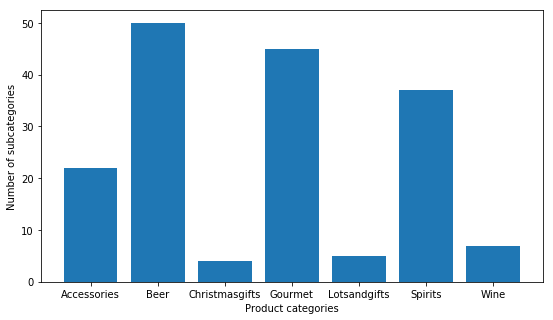

In [176]:
plt.figure(1, figsize=(9,5))
plt.bar(list(num_sub.index),list(num_sub))
plt.xlabel("Product categories")
plt.ylabel("Number of subcategories")


In [177]:
print("Average product mix depth:", round(num_sub.mean()))

Average product mix depth: 24


### Product mix depth: Average number of references per subcategorie

In [178]:
num_ref = df.groupby('Product subcategorie').nunique()['Product reference']
print("Average number of references per subcategorie:",round(num_ref.mean(),0))

Average number of references per subcategorie: 344.0


### Product mix length

In [179]:
print("Length of the product mix: ",len(df["Product reference"].unique()),"references")

Length of the product mix:  57731 references


# 5. Suppliers analysis

In [180]:
# Top suppliers
df_supp = df.groupby(['Supplier ID','Supplier country']).count()["Order Id"]
df_supp = df_supp.sort_values()
print("Top 5 suppliers ID: ")
df_supp.tail(5)

Top 5 suppliers ID: 


Supplier ID  Supplier country
1            Spain               23692
86           Spain               31237
124          Spain               38238
92           Spain               58278
6            Spain               62110
Name: Order Id, dtype: int64

In [181]:
# Number of suppliers per country
num_supp = df.groupby('Supplier country').nunique()["Supplier ID"]
print(num_supp)

Supplier country
Belgium            4
France            47
Germany           24
Greece             1
Italy             34
Luxembourg         1
Netherlands        9
Portugal          13
Serbia             1
Spain            109
UnitedKingdom     23
Name: Supplier ID, dtype: int64


### Top suppliers per category

In [183]:
df.groupby(['Product categorie','Supplier ID']).nunique()\
                                               .drop(['Supplier ID','Product categorie'],axis=1)\
                                               .reset_index()\
                                               .sort_values(['Product categorie','Product reference'],ascending=False)\
                                               .groupby(['Product categorie'])['Product categorie','Supplier ID'].head(3)




,Product categorie,Supplier ID
400,Wine,6
541,Wine,165
395,Wine,1
253,Spirits,6
300,Spirits,92
263,Spirits,19
207,Lotsandgifts,86
232,Lotsandgifts,163
182,Lotsandgifts,23
88,Gourmet,1


# 6. Market basket analysis : Association rules

In [184]:
df.head()

,Order Id,Product categorie,Product subcategorie,Product reference,Product quantity,Total price,Supplier country,Supplier ID,Unit price
0,61865,Spirits,Anise,483222,2,14.90,Spain,1,7.45
1,62447,Wine,Rosé,822222,12,64.20,Spain,1,5.35
2,64401,Spirits,Herballiquor,434732,1,13.15,Spain,2,13.15
3,64588,Wine,red,600772,30,172.50,Spain,3,5.75
4,64674,Spirits,Tequila,857357,1,36.70,Spain,1,36.70


In [185]:
pivot_table = pd.pivot_table(df,columns = ['Product subcategorie'],values = 'Product quantity', index = ['Order Id'])
pivot_table.head()

Product subcategorie,Abbey,Absinthe,Absintheserviceaccessories,Accessories,Aerators&oxygenators,Aguardiente,Alcohol-free,Ale,Algae,Altbier,...,Wineserviceaccessories,Winestooffer,WinterAle,deGarde,fortified,icebuckets,red,sparkling,sweet,white
Order Id,,,,,,,,,,,,,,,,,,,,,
61865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
64674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:

def encode_values(x):
    if x == True:
        return 0
    else:
        return 1    

pivot_table = pivot_table.isna()
pivot_table = pivot_table.applymap(encode_values)
pivot_table.head()

Product subcategorie,Abbey,Absinthe,Absintheserviceaccessories,Accessories,Aerators&oxygenators,Aguardiente,Alcohol-free,Ale,Algae,Altbier,...,Wineserviceaccessories,Winestooffer,WinterAle,deGarde,fortified,icebuckets,red,sparkling,sweet,white
Order Id,,,,,,,,,,,,,,,,,,,,,
61865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
64674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
pivot_table.sum()

Product subcategorie
Abbey                           403
Absinthe                       1274
Absintheserviceaccessories      208
Accessories                      39
Aerators&oxygenators              6
Aguardiente                    1148
Alcohol-free                    571
Ale                             704
Algae                             4
Altbier                           9
Amaretto                        472
AmbrÃ©ebeer                      77
AmericanPaleAle                  10
Anise                          1864
Appetizers                       31
Armagnac                        630
Aromakits                       130
Bakery                           23
Barleywine                       76
BelgianStrongPaleAle              4
Bio                               4
Bitter                          828
BlackIPA                          3
Blackbeer                       145
BlondAle                        122
Bock                             59
Books                             6
Bottler

In [188]:
frequent_itemsets = apriori(pivot_table, min_support=0.001, use_colnames=True)

In [189]:
rules = association_rules(frequent_itemsets, metric="lift")
rules = rules.sort_values('confidence',ascending=False)
#rules.head()
rules[['antecedents','consequents','confidence']].head(16)


,antecedents,consequents,confidence
242,"(Vodka, Pastis)",(Whiskey),0.672165
235,"(Rum, Pastis)",(Whiskey),0.639037
278,"(white, fortified)",(red),0.600398
165,"(Rum, Cognac)",(Whiskey),0.598361
172,"(Vodka, Cognac)",(Whiskey),0.597973
285,"(white, sparkling)",(red),0.593766
117,"(Rum, Bourbon)",(Whiskey),0.579345
275,"(white, Whiskey)",(red),0.553229
176,"(Rum, Fruitliquor)",(Vodka),0.546512
252,"(Rosé, red)",(white),0.540500
